# **2. PyData and PyGMT - plotting data on maps**

In this tutorial, we'll be using tools from the [PyData](https://pydata.org) ecosystem's stack
to load in point and grid datasets via
[pandas](https://pandas.pydata.org) and [xarray](http://xarray.pydata.org) respectively.
We will then learn how to plot these on a map via [PyGMT](https://www.pygmt.org).
Those familiar with [matplotlib](https://matplotlib.org) will find the syntax to be rather similar,
but [PyGMT](https://www.pygmt.org/dev/overview) has a greater focus on producing high quality vector graphic maps
for publications, posters, talks, etc that is more suited for a geospatial audience.

## **Getting started**

We'll start by importing the Python libraries we'll be using.
Following common conventions, we'll abbreviate
[pandas](https://pandas.pydata.org) as `pd` and
[xarray](http://xarray.pydata.org) as `xr`.
A little later into this tutorial,
we'll also make use of
[rioxarray](https://corteva.github.io/rioxarray) and
[scikit-image](https://scikit-image.org).

In [1]:
import pandas as pd
import pygmt
import rioxarray
import skimage.exposure
import xarray as xr

## **2.1 Loading and plotting points**

Now let's have a go at plotting our earthquake points on a map!
GMT really shines when it comes to plotting data on a map.

We'll use pandas to read in a CSV file of historical earthquakes from October 2018 to 2019
directly via the [GeoNet Quake Search](https://quakesearch.geonet.org.nz) API kindly provided
by the New Zealand GeoNet project and its sponsors EQC, GNS Science and LINZ.
Alternatively, you can read in your own csv file by passing in the path to a local file.

In [2]:
quakes = pd.read_csv(
    "https://quakesearch.geonet.org.nz/csv?minmag=4&bbox=160,-50,185,-10&startdate=2018-10-01T0:00:00&enddate=2019-10-31T1:00:00",
    skipinitialspace=True
)

We can preview the first few columns of the pandas.DataFrame
to see what the earthquake data looks like.

In [3]:
quakes.head()

publicid                    eventtype                origintime  \
0  2019p818103  outside of network interest  2019-10-30T16:44:02.398Z   
1  2019p815782  outside of network interest  2019-10-29T20:07:53.767Z   
2  2019p815147                   earthquake  2019-10-29T14:30:51.601Z   
3  2019p814914  outside of network interest  2019-10-29T12:25:32.198Z   
4  2019p814451  outside of network interest  2019-10-29T08:16:29.191Z   

           modificationtime   longitude   latitude  magnitude       depth  \
0  2019-10-30T16:53:50.101Z -176.705078 -30.636597   5.304123   33.000000   
1  2019-10-30T02:08:39.258Z -179.889191 -31.375284   4.236141  461.060333   
2  2019-10-29T14:39:01.714Z  166.067368 -46.224545   4.274113   12.000000   
3  2019-10-29T12:32:41.845Z -179.789108 -31.911573   4.878556  379.071075   
4  2019-10-29T08:36:36.421Z -176.667450 -23.353836   4.962331  150.010071   

  magnitudetype          depthtype  ... evaluationstatus evaluationmode  \
0           MLv  operator assigned  ...        confirmed         manual   
1            mB                NaN  ...        confirmed         manual   
2             M  operator assigned  ...        confirmed         manual   
3           MLv                NaN  ...        confirmed         manual   
4            mB                NaN  ...        confirmed         manual   

  earthmodel usedphasecount  usedstationcount  magnitudestationcount  \
0     iasp91             22                18                      4   
1     iasp91             34                32                     11   
2     iasp91             22                17                     15   
3     iasp91             29                25                     32   
4     iasp91             36                34                     38   

   minimumdistance  azimuthalgap  originerror  magnitudeuncertainty  
0         1.728889    243.925430     1.903137              0.091844  
1         6.349005    345.929810     0.791823              0.183426  
2         0.429999    285.516861     0.914399              0.000000  
3         3.093721    161.610609     0.880250              0.240965  
4         5.990378    143.094313     3.008184              0.139555  

[5 rows x 21 columns]

Now let's start a new figure by creating a blank instance of `pygmt.Figure`,
this time though, we'll set our focus to Fiji (FJ) instead.
We'll also use [pygmt.Figure.text](https://www.pygmt.org/dev/api/generated/pygmt.Figure.text)
to plot the country's capital Suva at a suitable coordinate.

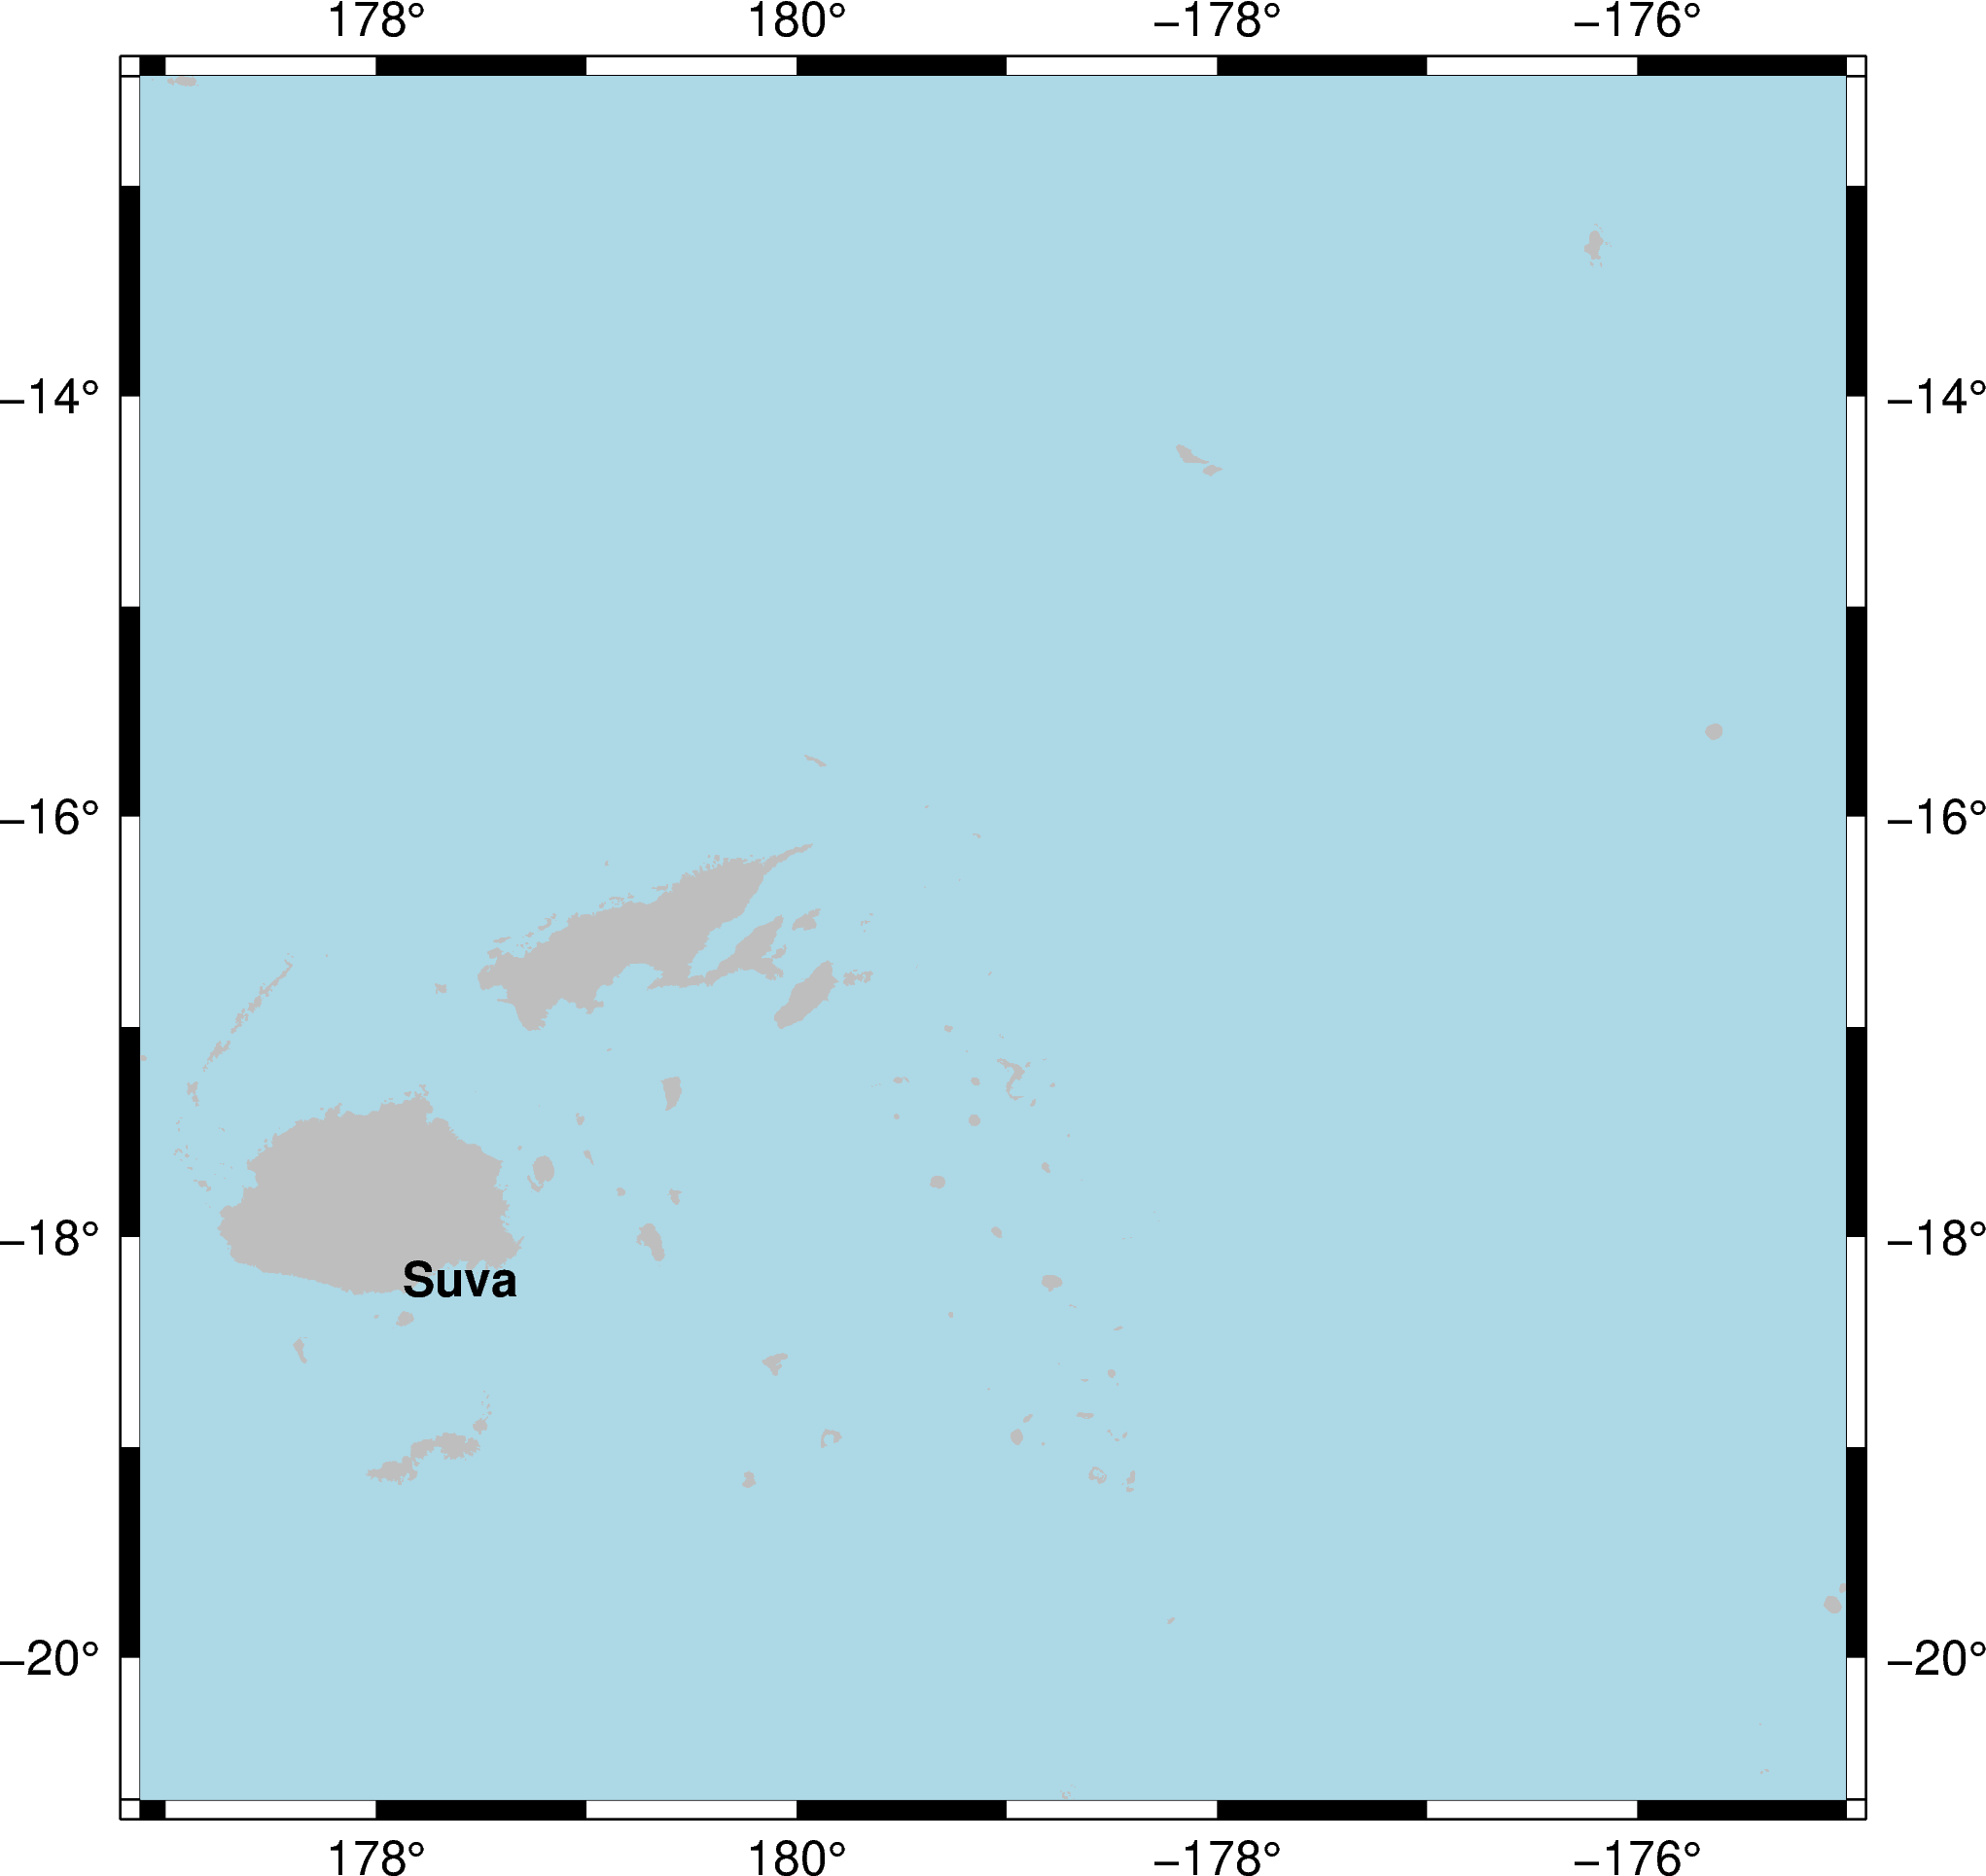

In [4]:
fig = pygmt.Figure()
fig.basemap(region="FJ", frame=True)
fig.coast(land="grey", water="lightblue")
fig.text(x=178.4, y=-18.2, text="Suva", font="12p,Helvetica-Bold,black")
fig.show()

The [pygmt.Figure.plot](https://www.pygmt.org/dev/api/generated/pygmt.Figure.plot) method
is used to plot the points.

You'll notice that our "quakes" table has 'longitude' and 'latitude' columns,
and we'll pass those into the `x` and `y` arguments of `plot`.
We set the `style` as 'c0.3c' which means circles of 0.3 cm in size,
The `pen` attribute controls the outline of the symbols and `color` controls the fill.

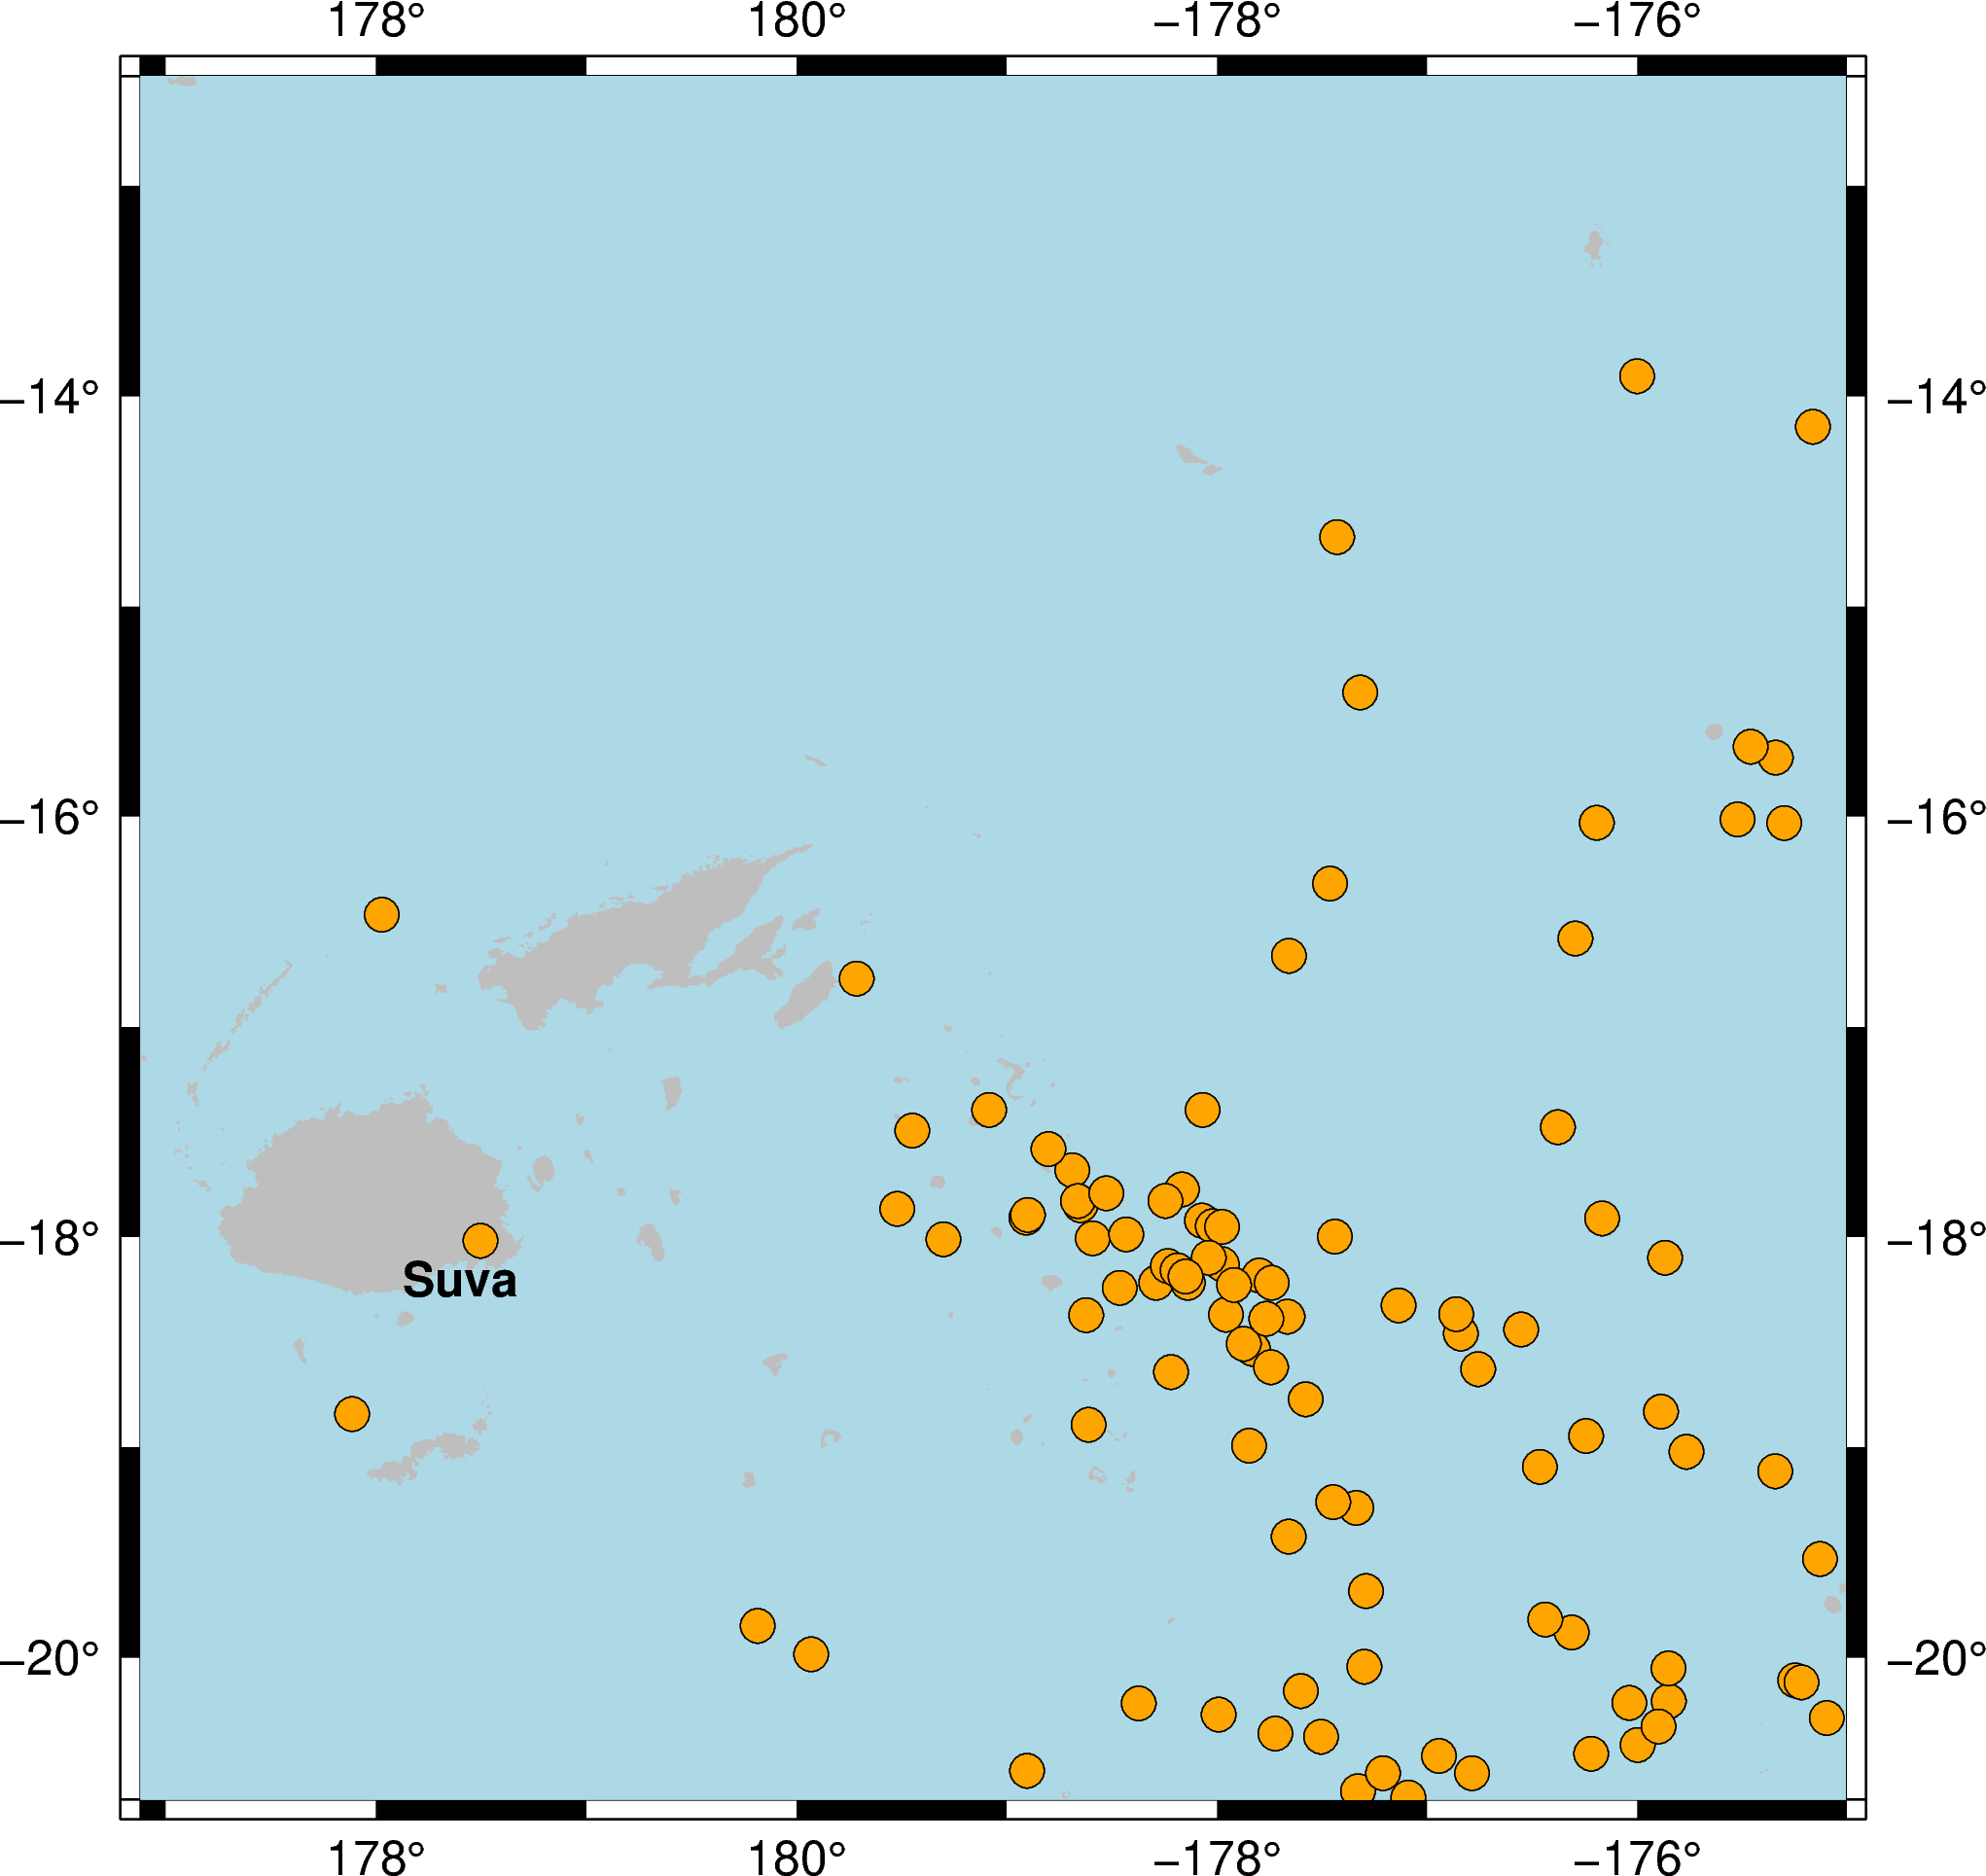

In [5]:
fig.plot(x=quakes.longitude, y=quakes.latitude, style="c0.3c", pen="black", color="orange")
fig.show()

### **Changing the colour of points**

We can also colour the circles according to the earthquake's magnitude.
Let's start by creating a new `pygmt.Figure` once more.

In [6]:
fig = pygmt.Figure()
fig.basemap(region="FJ", frame=["af", '+t"Earthquakes near Fiji"'])
fig.coast(land="grey", water="lightblue")
fig.text(x=178.4, y=-18.2, text="Suva", font="12p,Helvetica-Bold,black")

Next, we'll create a color palette table (cpt) using
[pygmt.makecpt](https://www.pygmt.org/dev/api/generated/pygmt.makecpt),
scaling it to an appropriate range or `series`, which is about 3.5 to 6.5 in this case.
We need to do this because most of GMT's
[built-in color palette tables](https://docs.generic-mapping-tools.org/latest/cookbook/cpts.html#built-in-color-palette-tables-cpt)
assume a data range of values between 0 and 1,
and our earthquake magnitudes fall outside of that range.

We'll use the [scientific colourmap](http://www.fabiocrameri.ch/colourmaps.php) 'batlow' here,
but feel free to explore other alternatives for your own use case!

In [7]:
pygmt.makecpt(cmap="batlow", series=[3.5, 6.5])

After that, we then tell [pygmt.Figure.plot](https://www.pygmt.org/dev/api/generated/pygmt.Figure.plot)
to `color` the points using the 'magnitude' values.
GMT will automatically use the scaled cpt we just made if we setting `cmap` to True.

In [8]:
fig.plot(x=quakes.longitude, y=quakes.latitude, color=quakes.magnitude, style="c0.3c", cmap=True)

Lastly, we'll set a colorbar on the Bottom Center (BC) with an appropriate label.

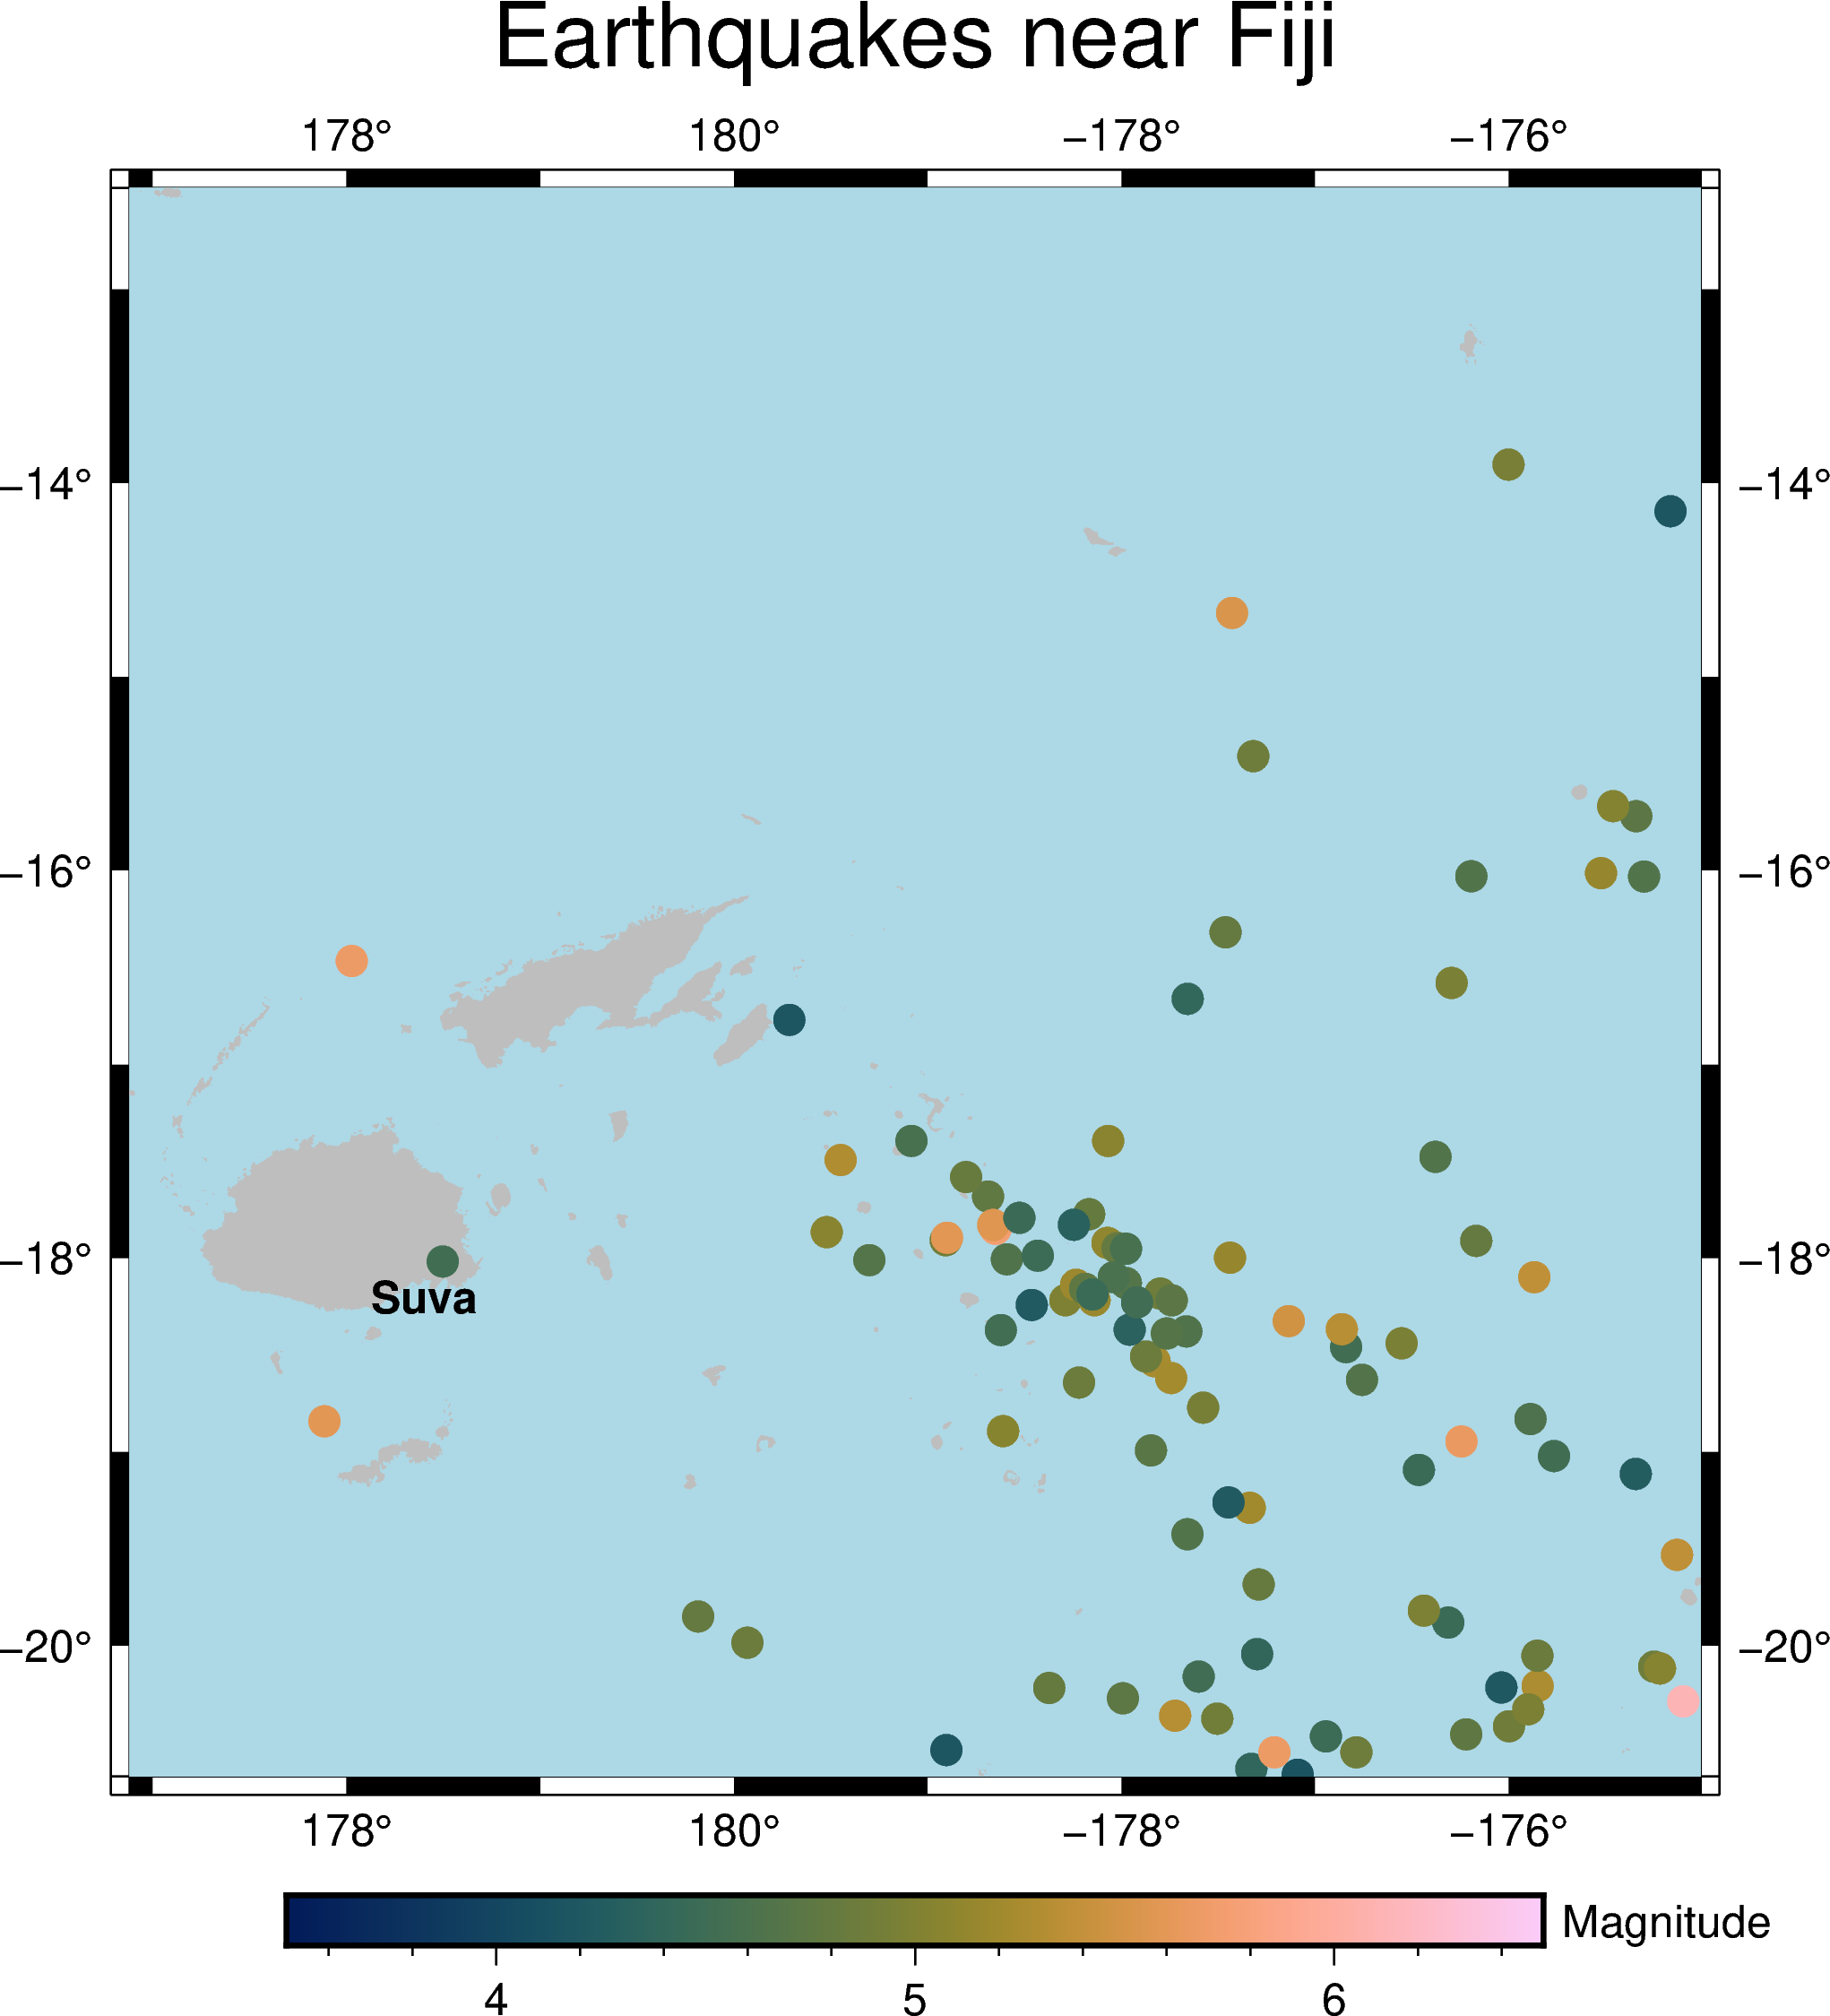

In [9]:
fig.colorbar(position="JBC", frame=["af", "y+lMagnitude"])
fig.show()

There are many other ways we can improve the display of points and other vector datasets on a map.
For example, you can follow this [tutorial](https://www.pygmt.org/dev/tutorials/plot.html#plotting-data-points)
to change the size of the points depending on the earthquake's magnitude.
There are also some [PyGMT gallery examples](https://www.pygmt.org/dev/gallery/index.html#plotting-map-items)
and pure [GMT gallery examples](https://docs.generic-mapping-tools.org/latest/gallery.html) you can
refer to for more inspiration.

We'll leave it here for now,
but just realize that [pygmt.Figure.plot](https://www.pygmt.org/dev/api/generated/pygmt.Figure.plot)
is a very powerful tool that can used for plotting lines, polygons and other symbols,
for not only maps but also non-geographic 2D plots as well!

## **2.2 Loading and plotting grids**

Now let's have a go at plotting some raster grids again!

This time though, we'll use [xarray](http://xarray.pydata.org) and [rasterio](https://github.com/mapbox/rasterio)
to load in a seamless 10 m spatial resolution bathymetry and topography DEM of Sydney Harbour
(published under a [CC BY 3.0](https://creativecommons.org/licenses/by/3.0/) license
by [Wilson and Power, 2018](https://doi.org/10.1594/PANGAEA.885014)).
The file is in an ESRI ASCII Raster format, but the workflow will be very similar for
[GeoTIFF](https://en.wikipedia.org/wiki/GeoTIFF) and [NetCDF](https://en.wikipedia.org/wiki/NetCDF) files,
or any of the file formats which xarray/rasterio can read in.

Note: The filename below looks funny because we're reading it directly from the web,
and unzipping the zip file 'on the fly' to get at the file we want
(see [here](https://rasterio.readthedocs.io/en/stable/topics/datasets.html#advanced-datasets) for more info).
Alternatively, you can substitute the filename to the path of a dataset stored locally.

In [10]:
grid = xr.open_rasterio(
    filename="zip+https://store.pangaea.de/Publications/WilsonK_etal_2018/Sydney.zip!Sydney/syd_10m_utm56.txt"
)

We can preview the resulting xarray.DataArray to look at some of the metadata and attributes.

In [11]:
grid

<xarray.DataArray (band: 1, y: 3490, x: 3931)>
[13719190 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.271e+06 6.271e+06 6.271e+06 ... 6.236e+06 6.236e+06
  * x        (x) float64 3.101e+05 3.101e+05 3.101e+05 ... 3.494e+05 3.494e+05
Attributes:
    transform:   (10.0, 0.0, 310090.0, 0.0, -10.0, 6271196.0)
    crs:         +init=epsg:32756
    res:         (10.0, 10.0)
    is_tiled:    0
    nodatavals:  (-9999.0,)
    scales:      (1.0,)
    offsets:     (0.0,)

PyGMT's [grdimage](https://www.pygmt.org/dev/api/generated/pygmt.Figure.grdimage) function
requires the grid to only have 2 dimensions (i.e. x and y),
but our grid currently has 3 (band, x and y) as denoted by the asterisk *.
We'll need to select just one of the bands (number 1 in this case)
so that things will work properly.

In [12]:
grid = grid.sel(band=1)
grid

<xarray.DataArray (y: 3490, x: 3931)>
[13719190 values with dtype=float32]
Coordinates:
    band     int64 1
  * y        (y) float64 6.271e+06 6.271e+06 6.271e+06 ... 6.236e+06 6.236e+06
  * x        (x) float64 3.101e+05 3.101e+05 3.101e+05 ... 3.494e+05 3.494e+05
Attributes:
    transform:   (10.0, 0.0, 310090.0, 0.0, -10.0, 6271196.0)
    crs:         +init=epsg:32756
    res:         (10.0, 10.0)
    is_tiled:    0
    nodatavals:  (-9999.0,)
    scales:      (1.0,)
    offsets:     (0.0,)

The next step is just some additional preprocessing.
We'll remove the NaN values so that they don't get plotted.

In [13]:
grid = grid.where(grid != grid.nodatavals, drop=True)
grid

<xarray.DataArray (y: 3488, x: 3931)>
array([[      nan,       nan,       nan, ..., -52.98272, -52.98294,
        -52.98289],
       [      nan,       nan,       nan, ..., -52.98257, -52.9828 ,
        -52.98275],
       [      nan,       nan,       nan, ..., -52.98326, -52.98349,
        -52.98344],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
    band     int64 1
  * y        (y) float64 6.271e+06 6.271e+06 6.271e+06 ... 6.236e+06 6.236e+06
  * x        (x) float64 3.101e+05 3.101e+05 3.101e+05 ... 3.494e+05 3.494e+05
Attributes:
    transform:   (10.0, 0.0, 310090.0, 0.0, -10.0, 6271196.0)
    crs:         +init=epsg:32756
    res:         (10.0, 10.0)
    is_tiled:    0
    nodatavals:  (-9999.0,)
    scales:      (1.0,)
    o

Finally, we can make our plot!
We'll create a color palette table (cpt) scaled to our minimum and maximum elevation.
Our colobar will be plotted on the Middle Right (MR) side with an X-offset of 1 cm,
and there will be a little square showing the NaN color (+n).

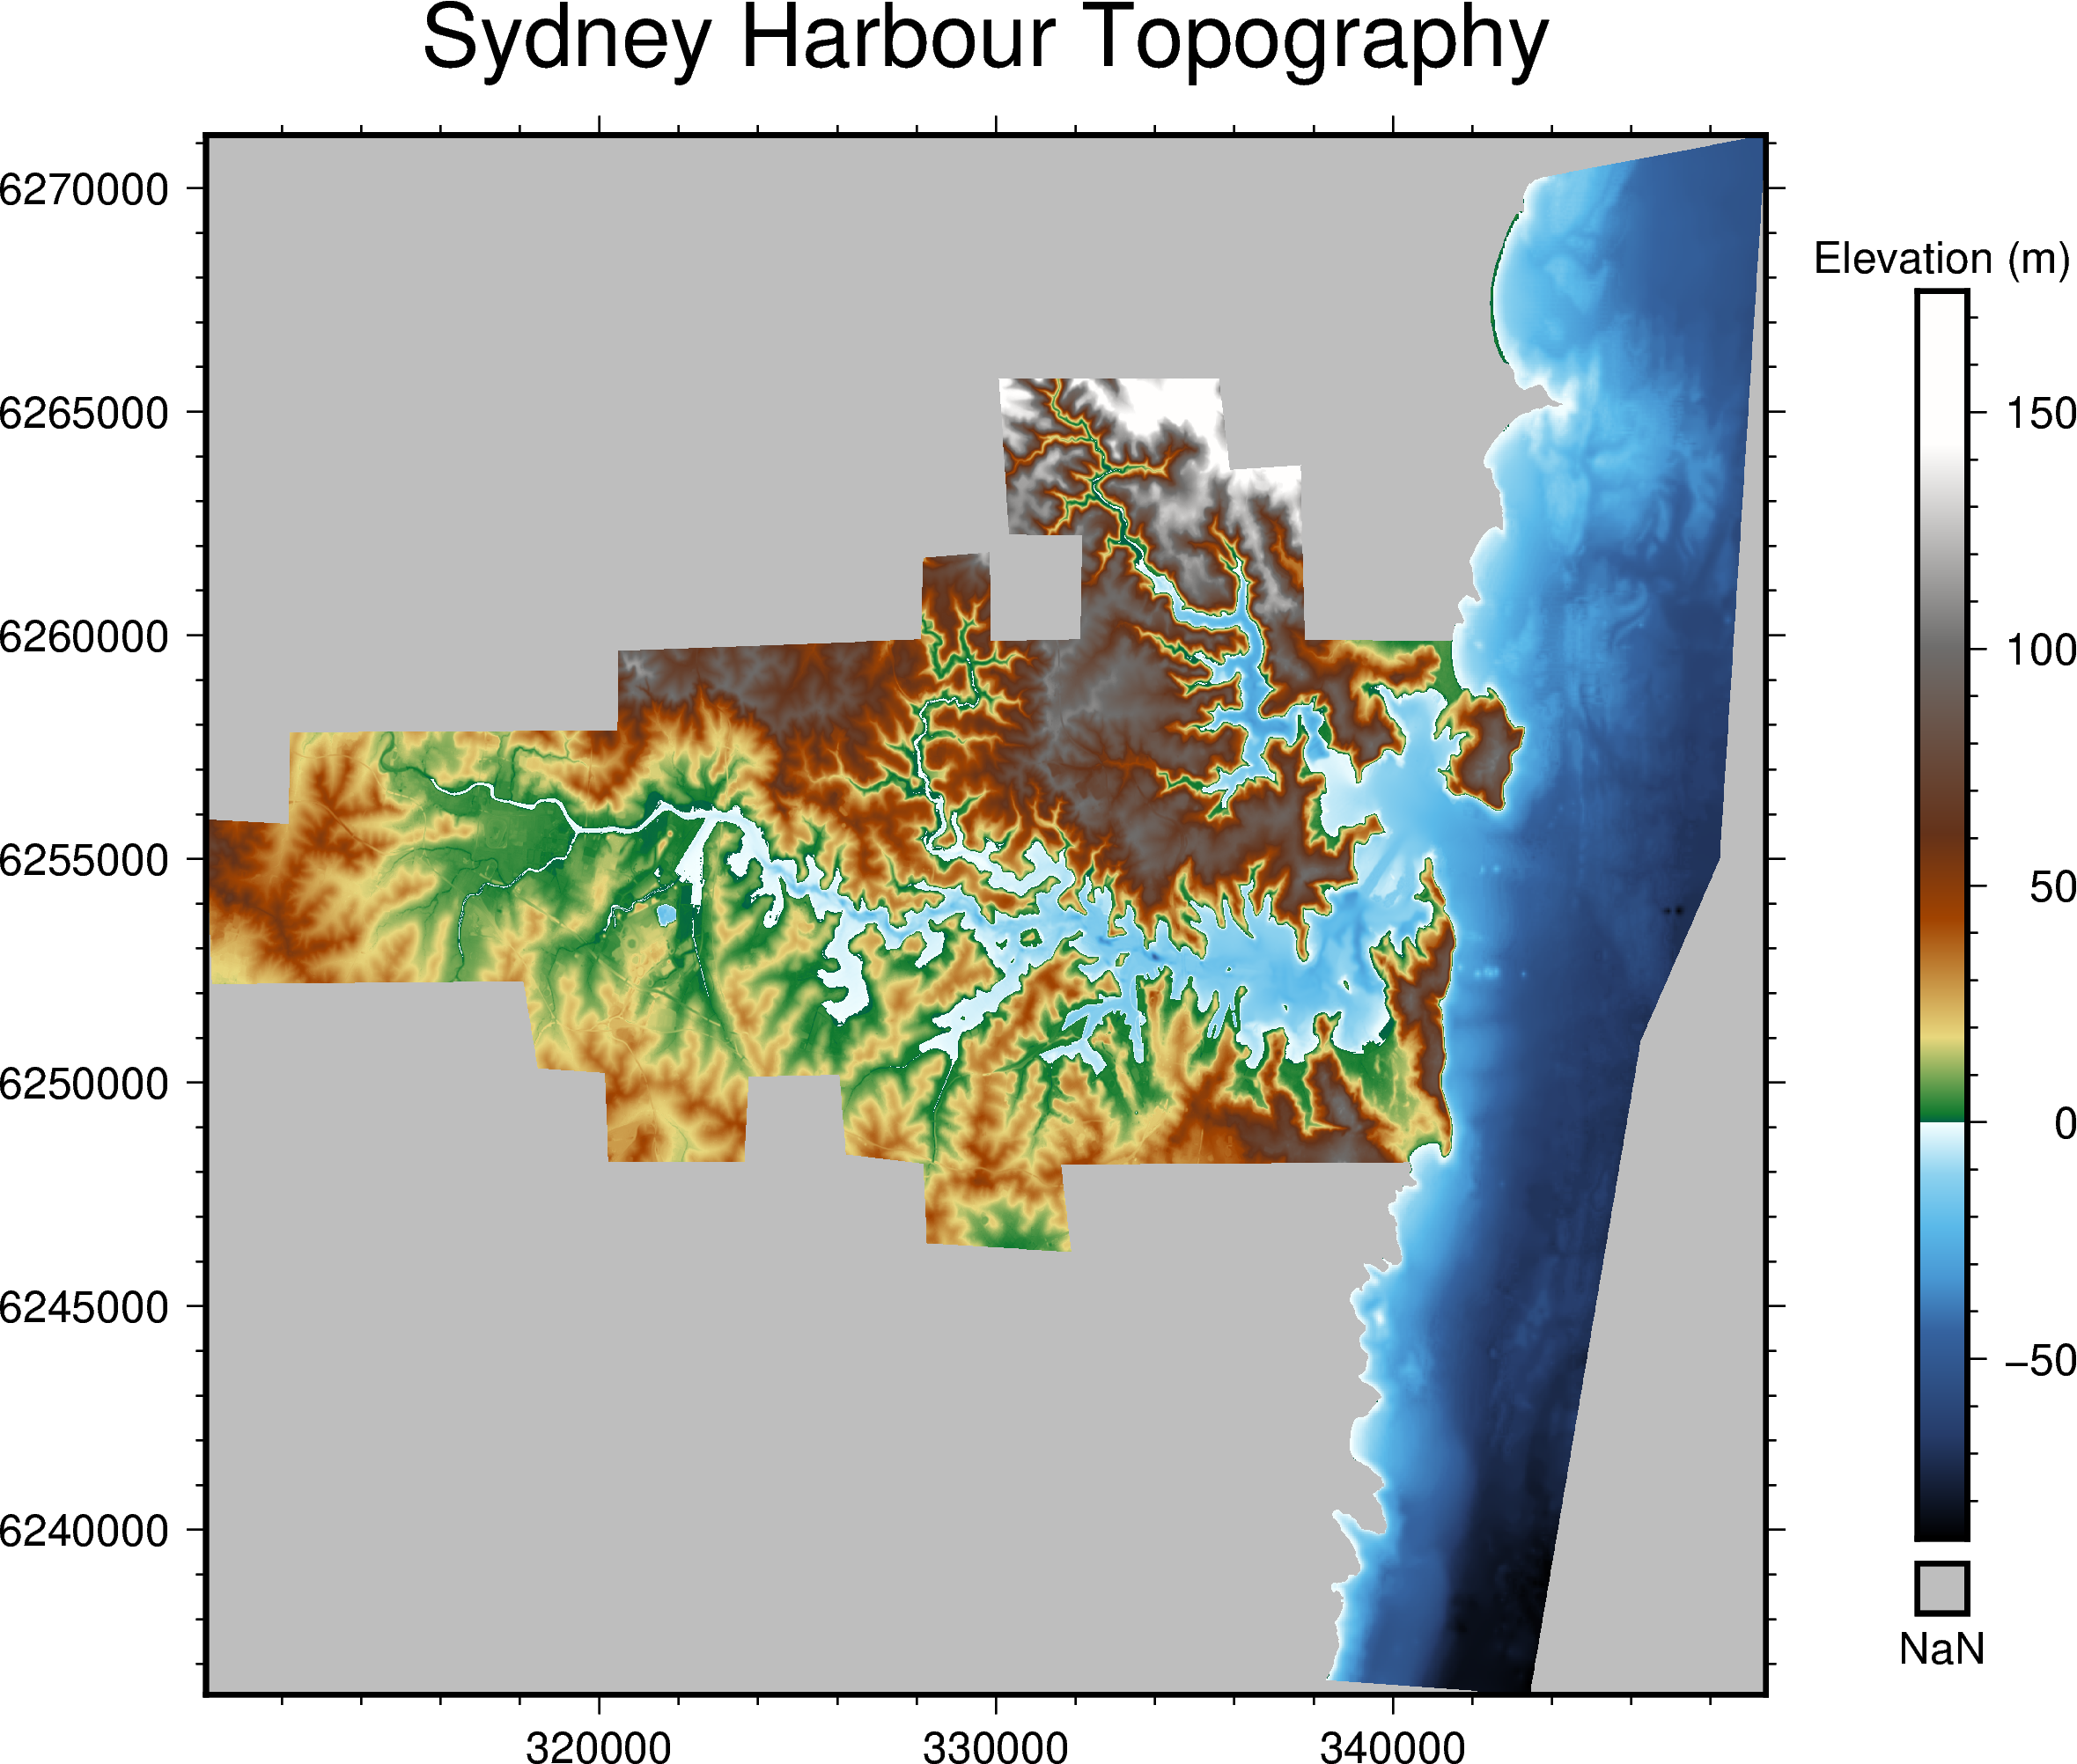

In [14]:
fig = pygmt.Figure()
pygmt.makecpt(series=[float(grid.min()), float(grid.max())], cmap="geo")
fig.grdimage(grid=grid, frame=["af", 'WSne+t"Sydney Harbour Topography"'])
fig.colorbar(position="JMR+n", frame=["af", 'y+l"Elevation (m)"'], X="1c")
fig.show()

**Additional Notes**

PyGMT currently has a few limitations when it comes with plotting grids.
Here is a list of some of the common ones (and their workarounds):

- The datatype (dtype) of the xarray.DataArray values must be either int/uint/float 32/64,
  (i.e. the standard uint/int16 found in many GeoTiff files won't work out of the box).
  - Workaround: Convert the dtype using `grid = grid.astype(dtype=np.uint32)`
- Large datasets stored in an xarray.DataArray may take a long time for PyGMT to plot.
  - Workaround: Subset your xarray grid using `grid.sel(x=slice(minx, maxx), y=slice(miny, maxy))`
  - Alternative: Pass in the filename to your grid directly, instead of loading it via xarray.
  

## **2.3 Looking at true colour bands**

What if your raster grid is not a DEM,
but a multi-band satellite image instead?
Well, grdimage also accepts RGB bands,
but there are a couple of tricks we'll need to learn for things to work properly.

Let's have a go at plotting a Landsat 8 Image of good ol' Wellington (and Cook Strait) this time.
To give you a quick sense of the place from space, we'll do a quick preview of the JPG image.

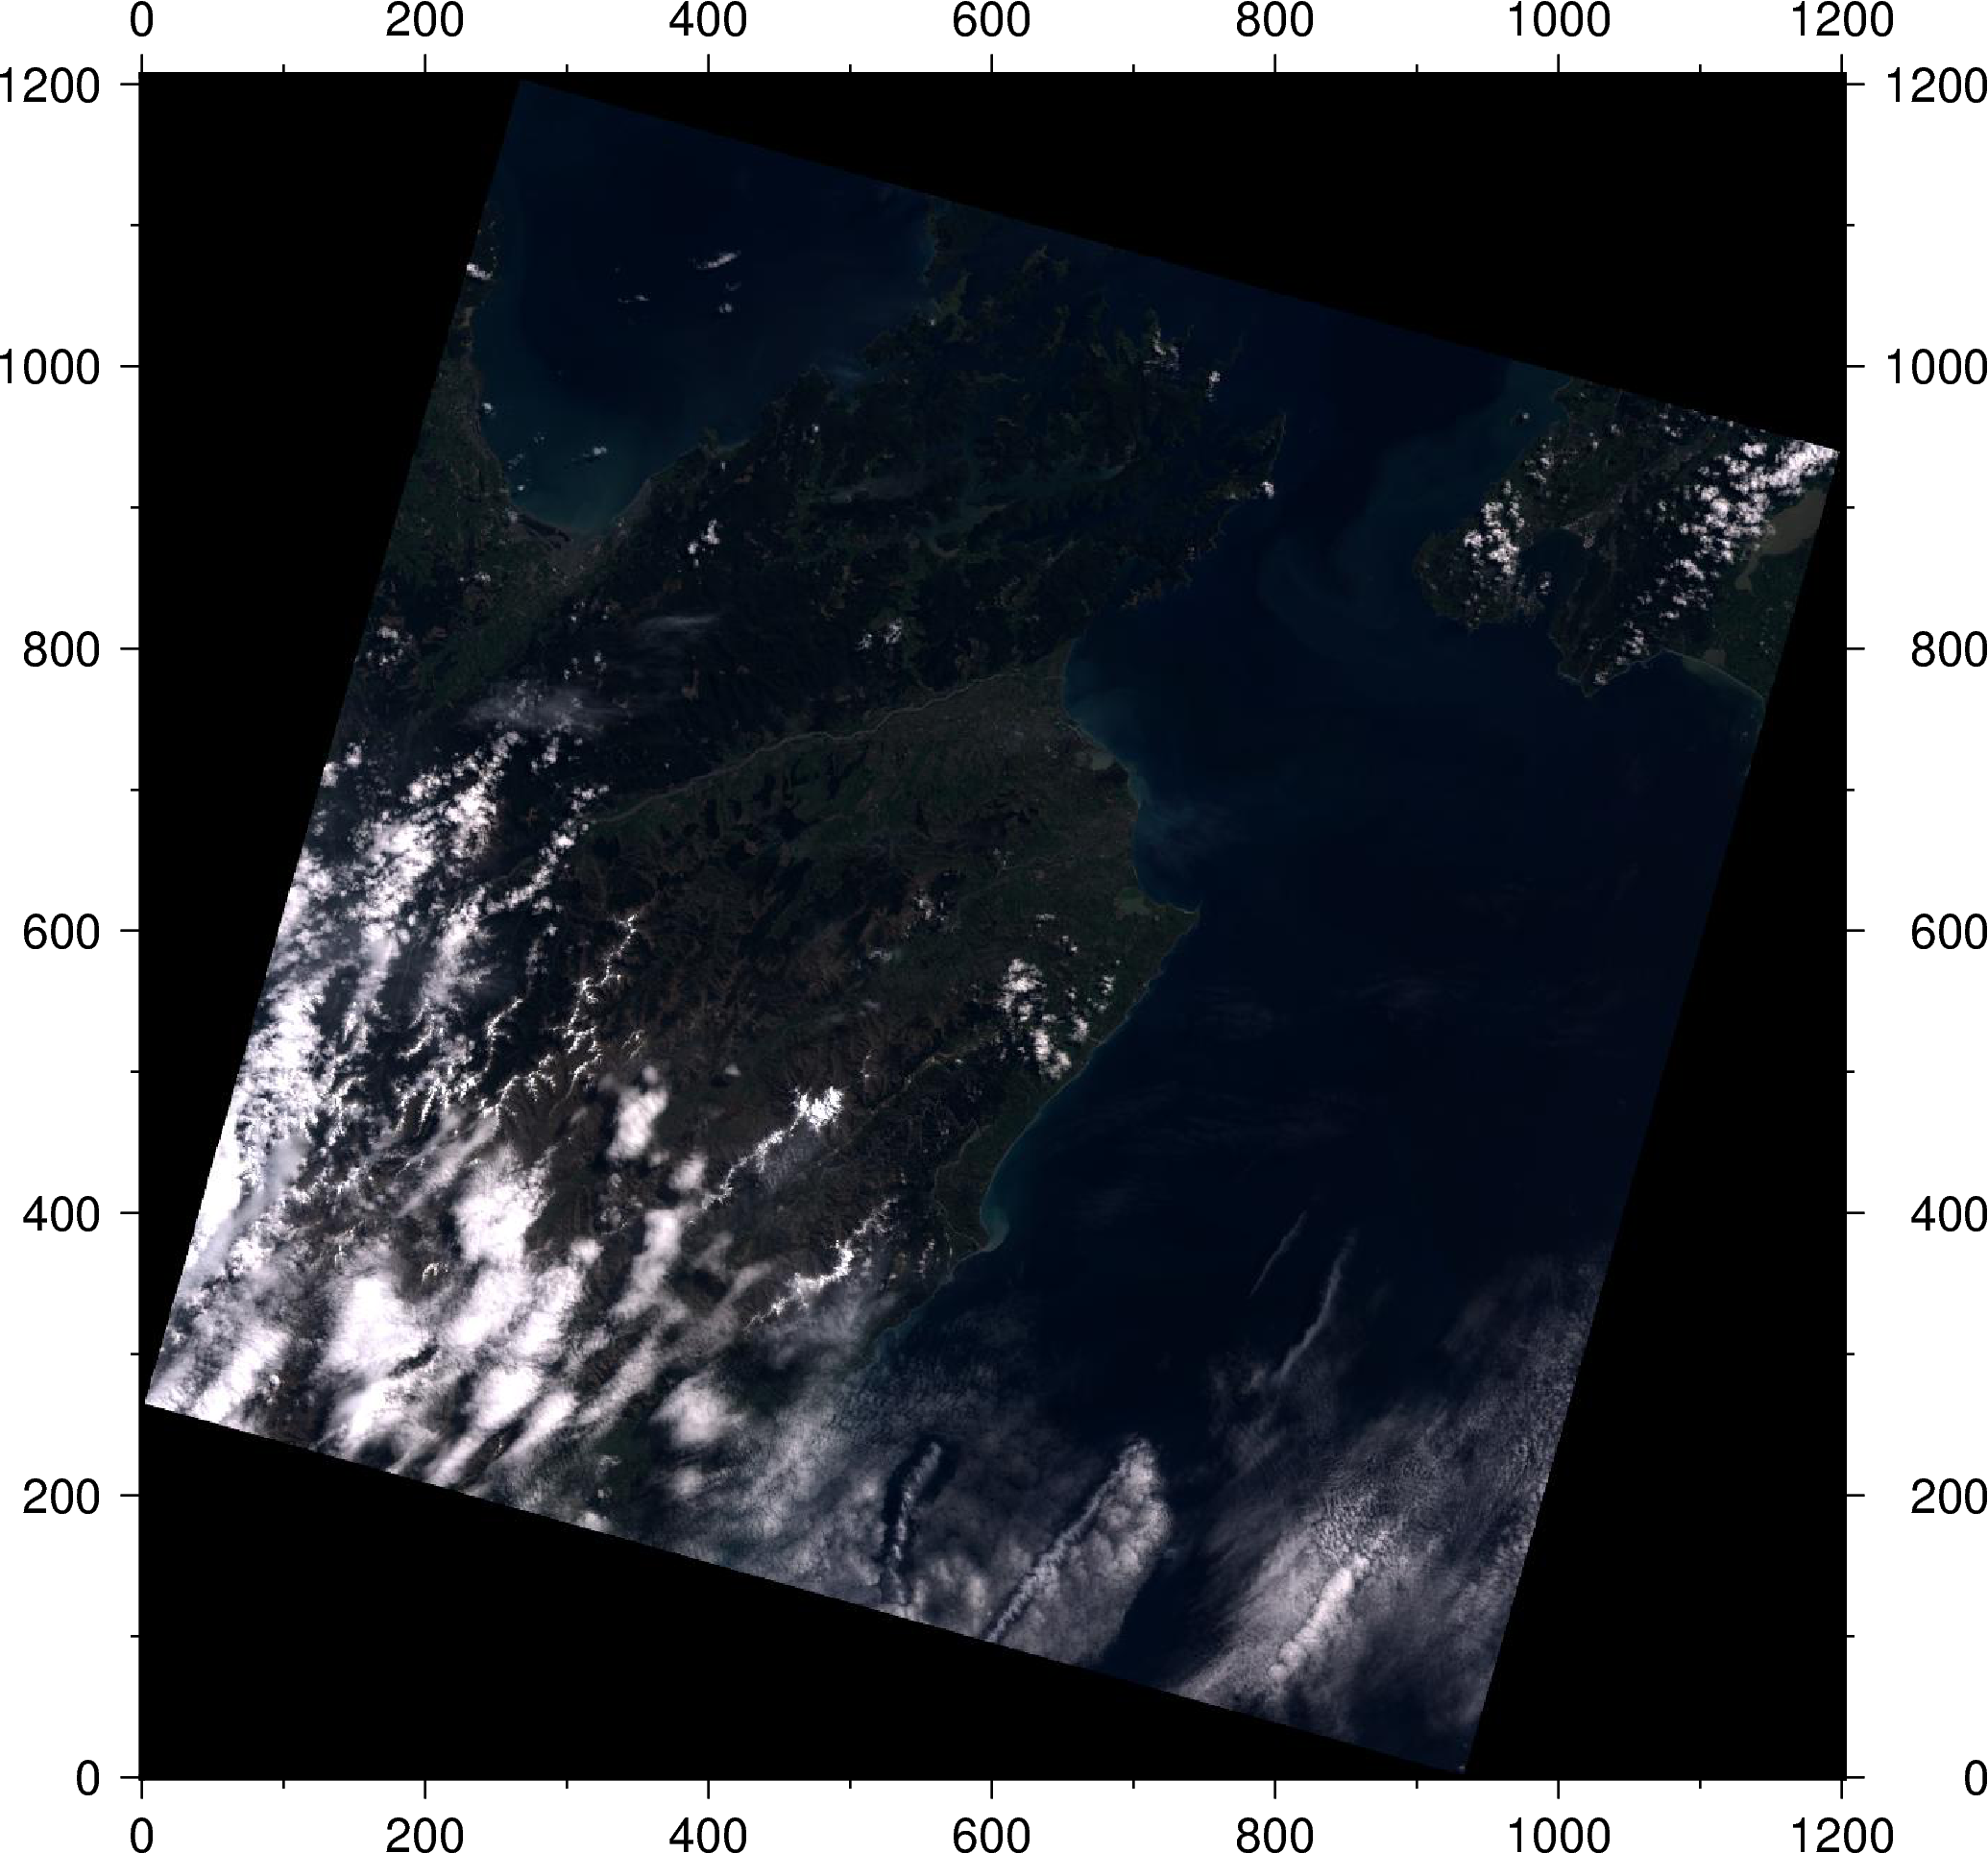

In [15]:
fig = pygmt.Figure()
fig.grdimage(
    grid="https://landsat-pds.s3.amazonaws.com/c1/L8/073/089/LC08_L1TP_073089_20191021_20191030_01_T1/LC08_L1TP_073089_20191021_20191030_01_T1_thumb_large.jpg",
    frame=True,
)
fig.show()

### **Getting some cloud optimized GeoTIFFs**

Landsat 8 data is provided as [cloud optimized GeoTIFFs (COGs)](https://www.cogeo.org/)
which makes it easy to pull down just what we need from the web.
I recommend using [Remote Pixel's Satellite Search API](https://search.remotepixel.ca) to search for images.

We'll switch from xarray to [rioxarray](https://corteva.github.io/rioxarray) this time,
just because it's open_rasterio method works better with COGs.
Instead of pulling down the full 30m resolution dataset,
let's keep it easy on the servers and use overview_level 1.

In [16]:
band = {}
for band_number in [4, 3, 2]:  # Landsat 8's Red, Green and Blue bands
    band[band_number] = rioxarray.open_rasterio(
        f"https://landsat-pds.s3.amazonaws.com/c1/L8/073/089/LC08_L1TP_073089_20191005_20191018_01_T1/LC08_L1TP_073089_20191005_20191018_01_T1_B{band_number}.TIF",
        overview_level=1,
        masked=True,
    ).squeeze()
band[3]  # preview the green band

<xarray.DataArray (y: 894, x: 891)>
[796554 values with dtype=float64]
Coordinates:
    band         int64 1
  * y            (y) float64 -4.507e+06 -4.507e+06 ... -4.748e+06 -4.748e+06
  * x            (x) float64 6.232e+05 6.235e+05 ... 8.63e+05 8.633e+05
    spatial_ref  int64 0
Attributes:
    transform:     (269.7306397306397, 0.0, 623085.0, 0.0, -269.8322147651007...
    scales:        (1.0,)
    offsets:       (0.0,)
    grid_mapping:  spatial_ref

We'll concatenate all the bands into a grid to save us having to write for-loops later.

In [17]:
grid = xr.concat(
    objs=[band[4], band[3], band[2]],
    dim=pd.Index(data=[4, 3, 2], name="band")
)

We can try to plot an RGB image by passing a list of the bands, but it won't turn out so good.

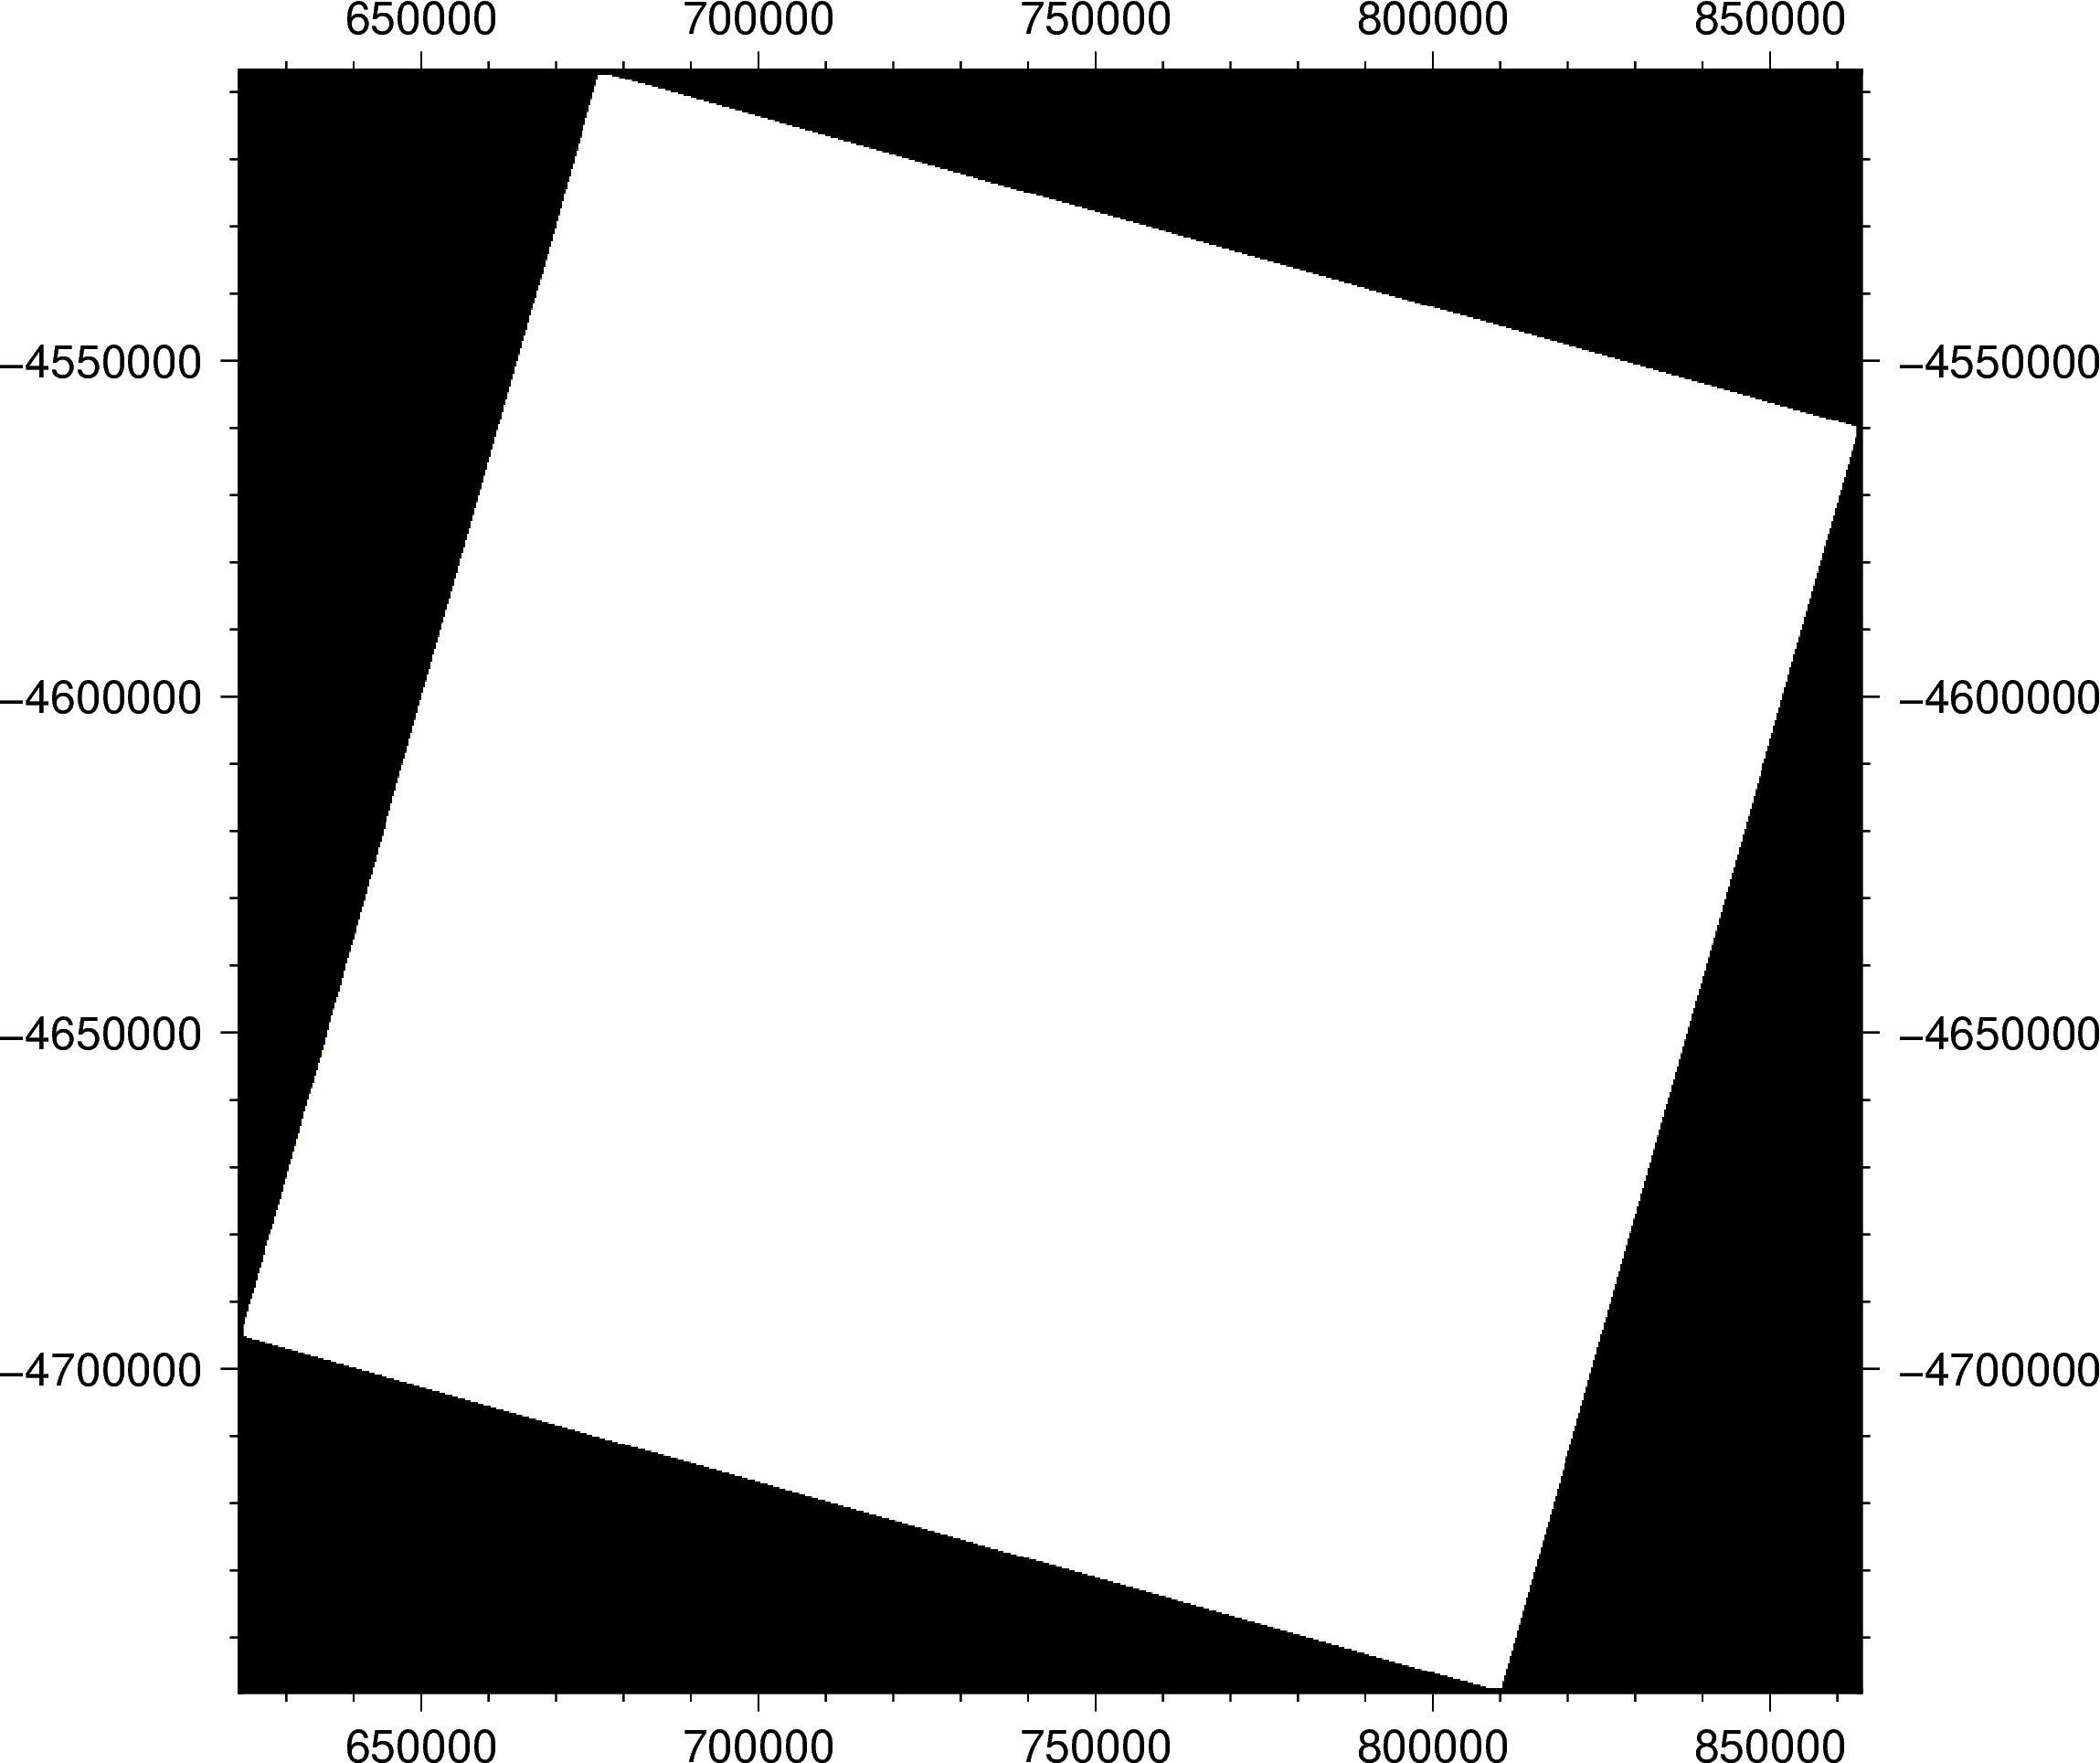

In [18]:
fig = pygmt.Figure()
fig.grdimage(grid=[grid.sel(band=4), grid.sel(band=3), grid.sel(band=2)], frame=True)
fig.show()

### **Scaling to 8 bits (0-255)**

Each band in a Landsat 8 GeoTIFF file has a dynamic range of 16 bits (0-65535).
However, in order to plot an RGB (red, green, blue) image in GMT,
each individual band needs to have their values scaled to between 0-255 (i.e. 8 bits).

GMT does have a [grdhisteq](https://docs.generic-mapping-tools.org/latest/grdhisteq.html) function
for histogram equalization,
but it is not available in PyGMT yet.
We'll use scikit-image's
[equalize_hist](https://scikit-image.org/docs/dev/api/skimage.exposure#skimage.exposure.equalize_hist)
function instead for now.

In [19]:
grid.values = 256 * skimage.exposure.equalize_hist(
    image=grid.values,
    nbins=2**16,  # 16 bit of Landsat 8
    mask=(grid != 0).values,  # don't include zero values in histogram stretch
)

### **Reproject and Plot**

Let's reproject our grid so that we can more easily reference coordinates in longitude and latitude later.

In [20]:
grid = grid.rio.reproject(
    "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
)

Now the image should look much nicer.

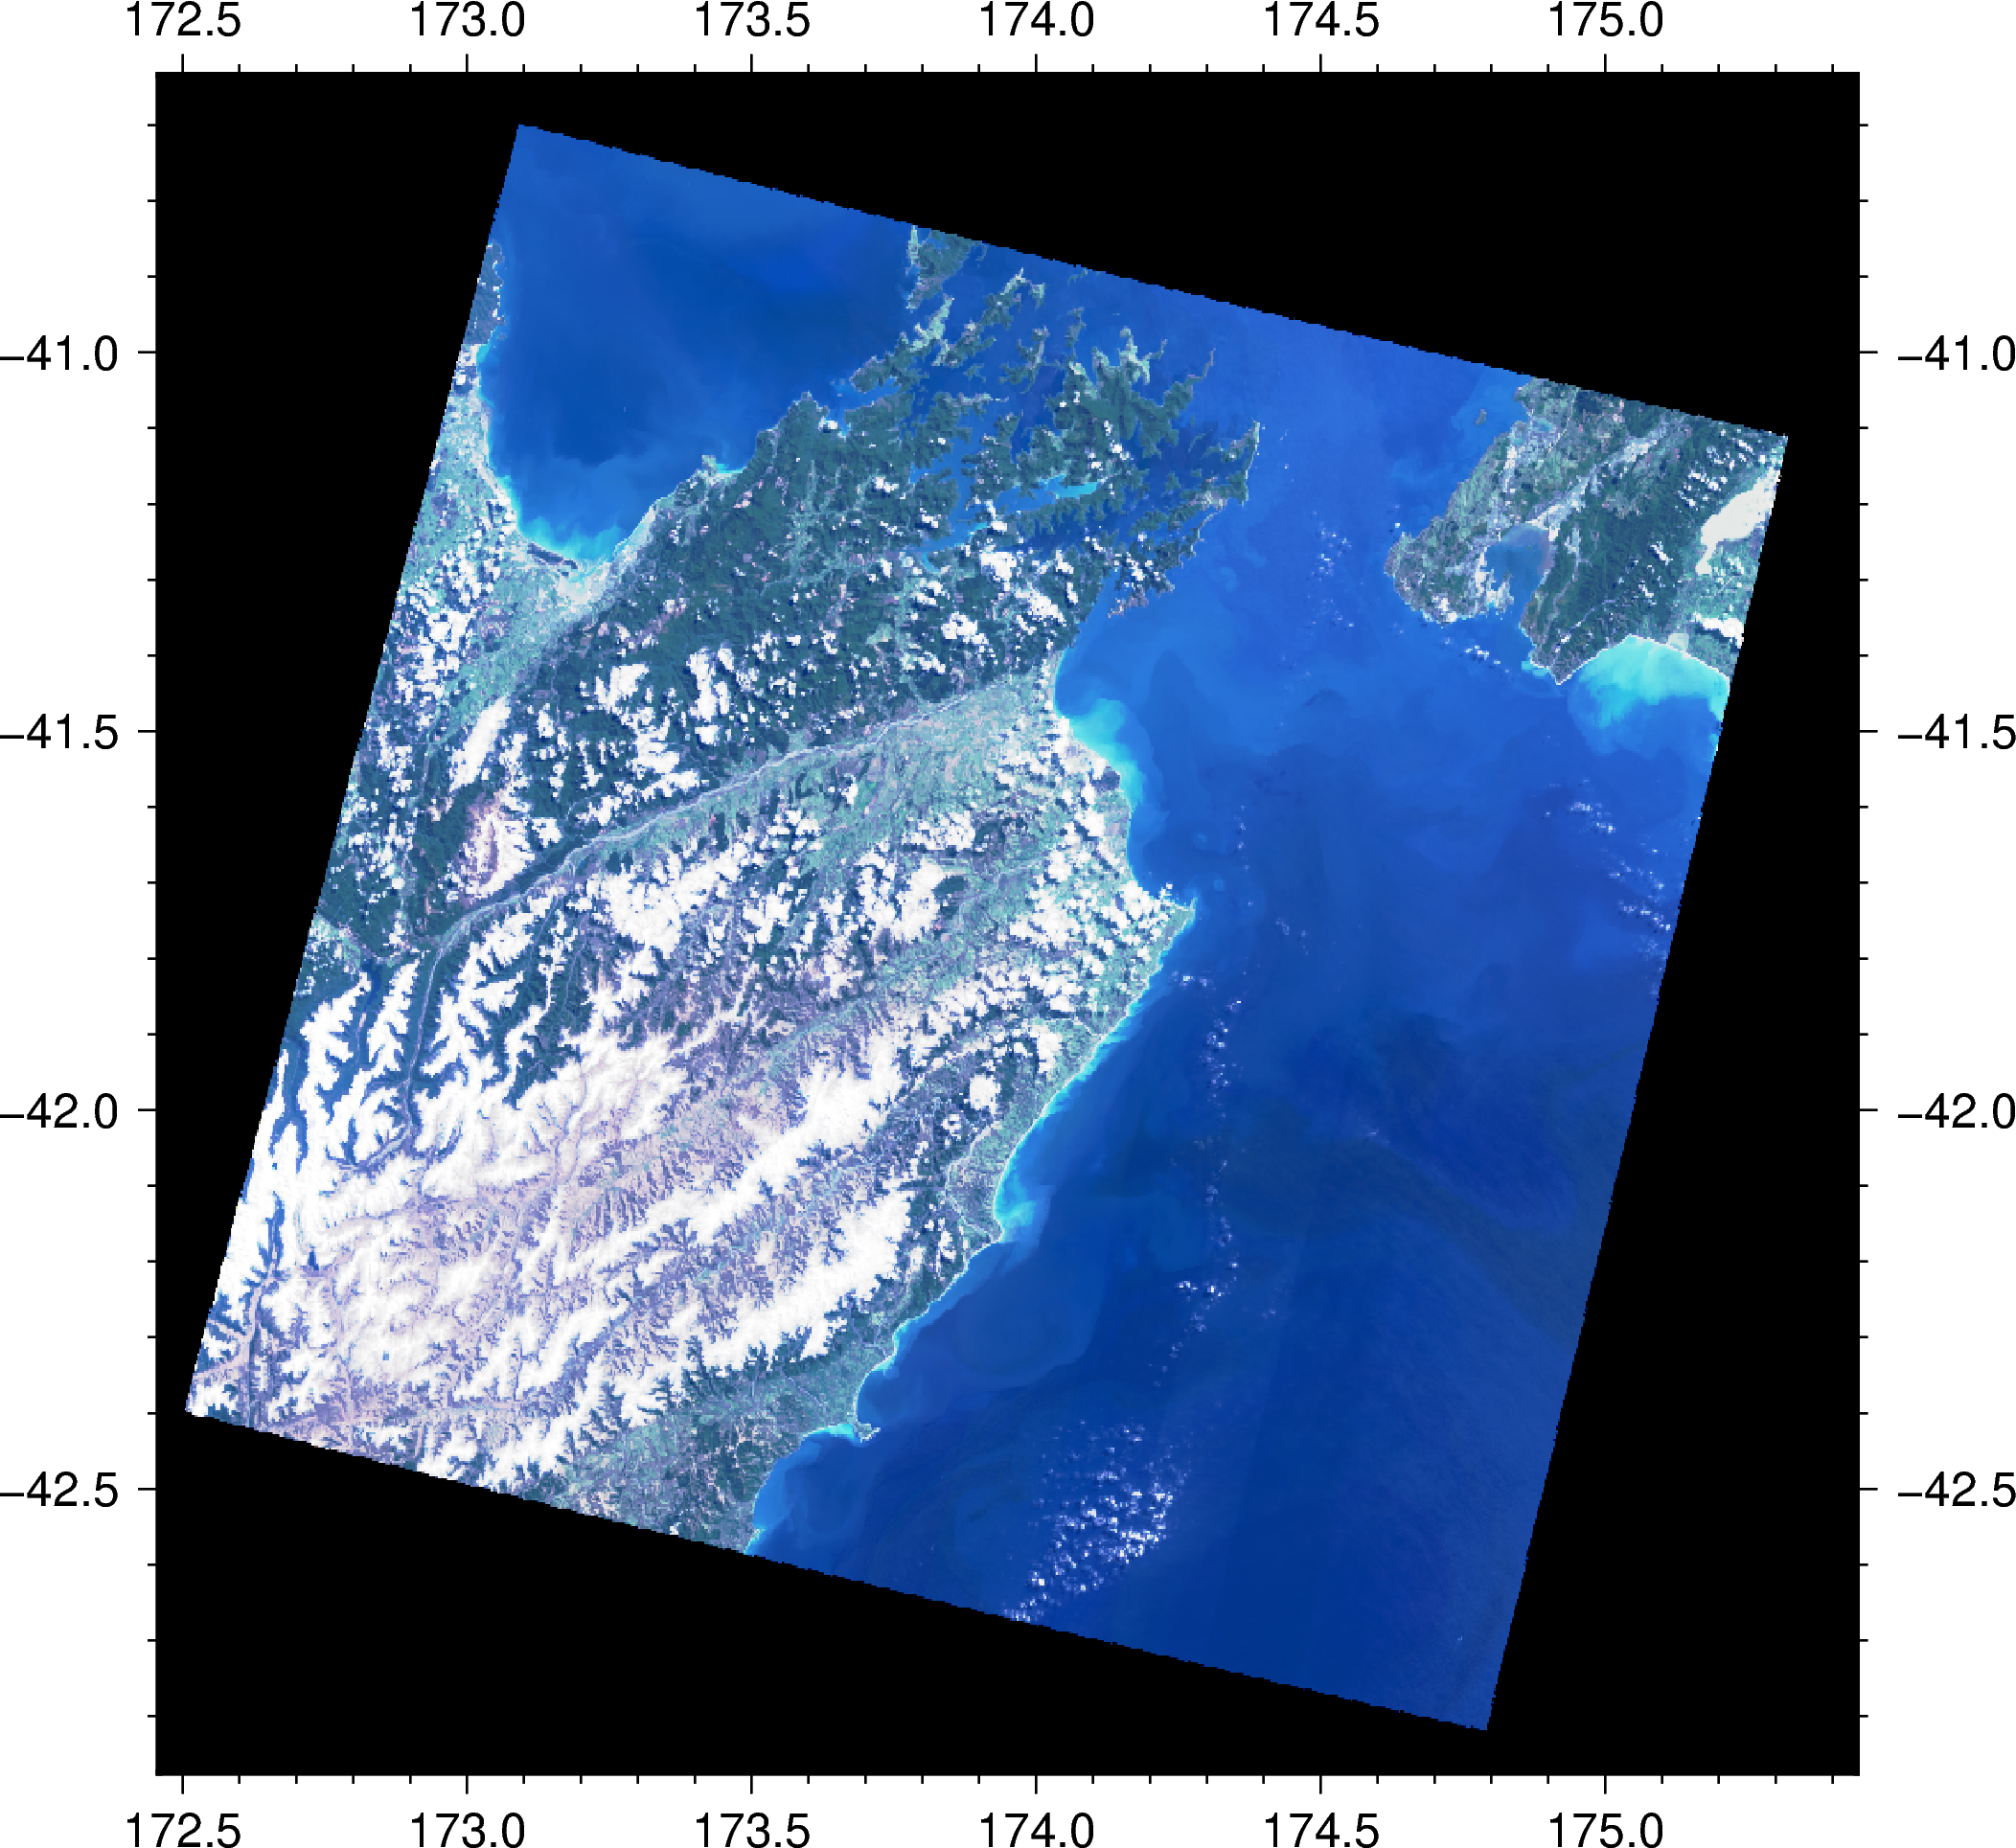

In [21]:
fig = pygmt.Figure()
fig.grdimage(grid=[grid.sel(band=4), grid.sel(band=3), grid.sel(band=2)], frame=True)
fig.show()

We can also subset our map to that of Wellington using the region argument as usual.

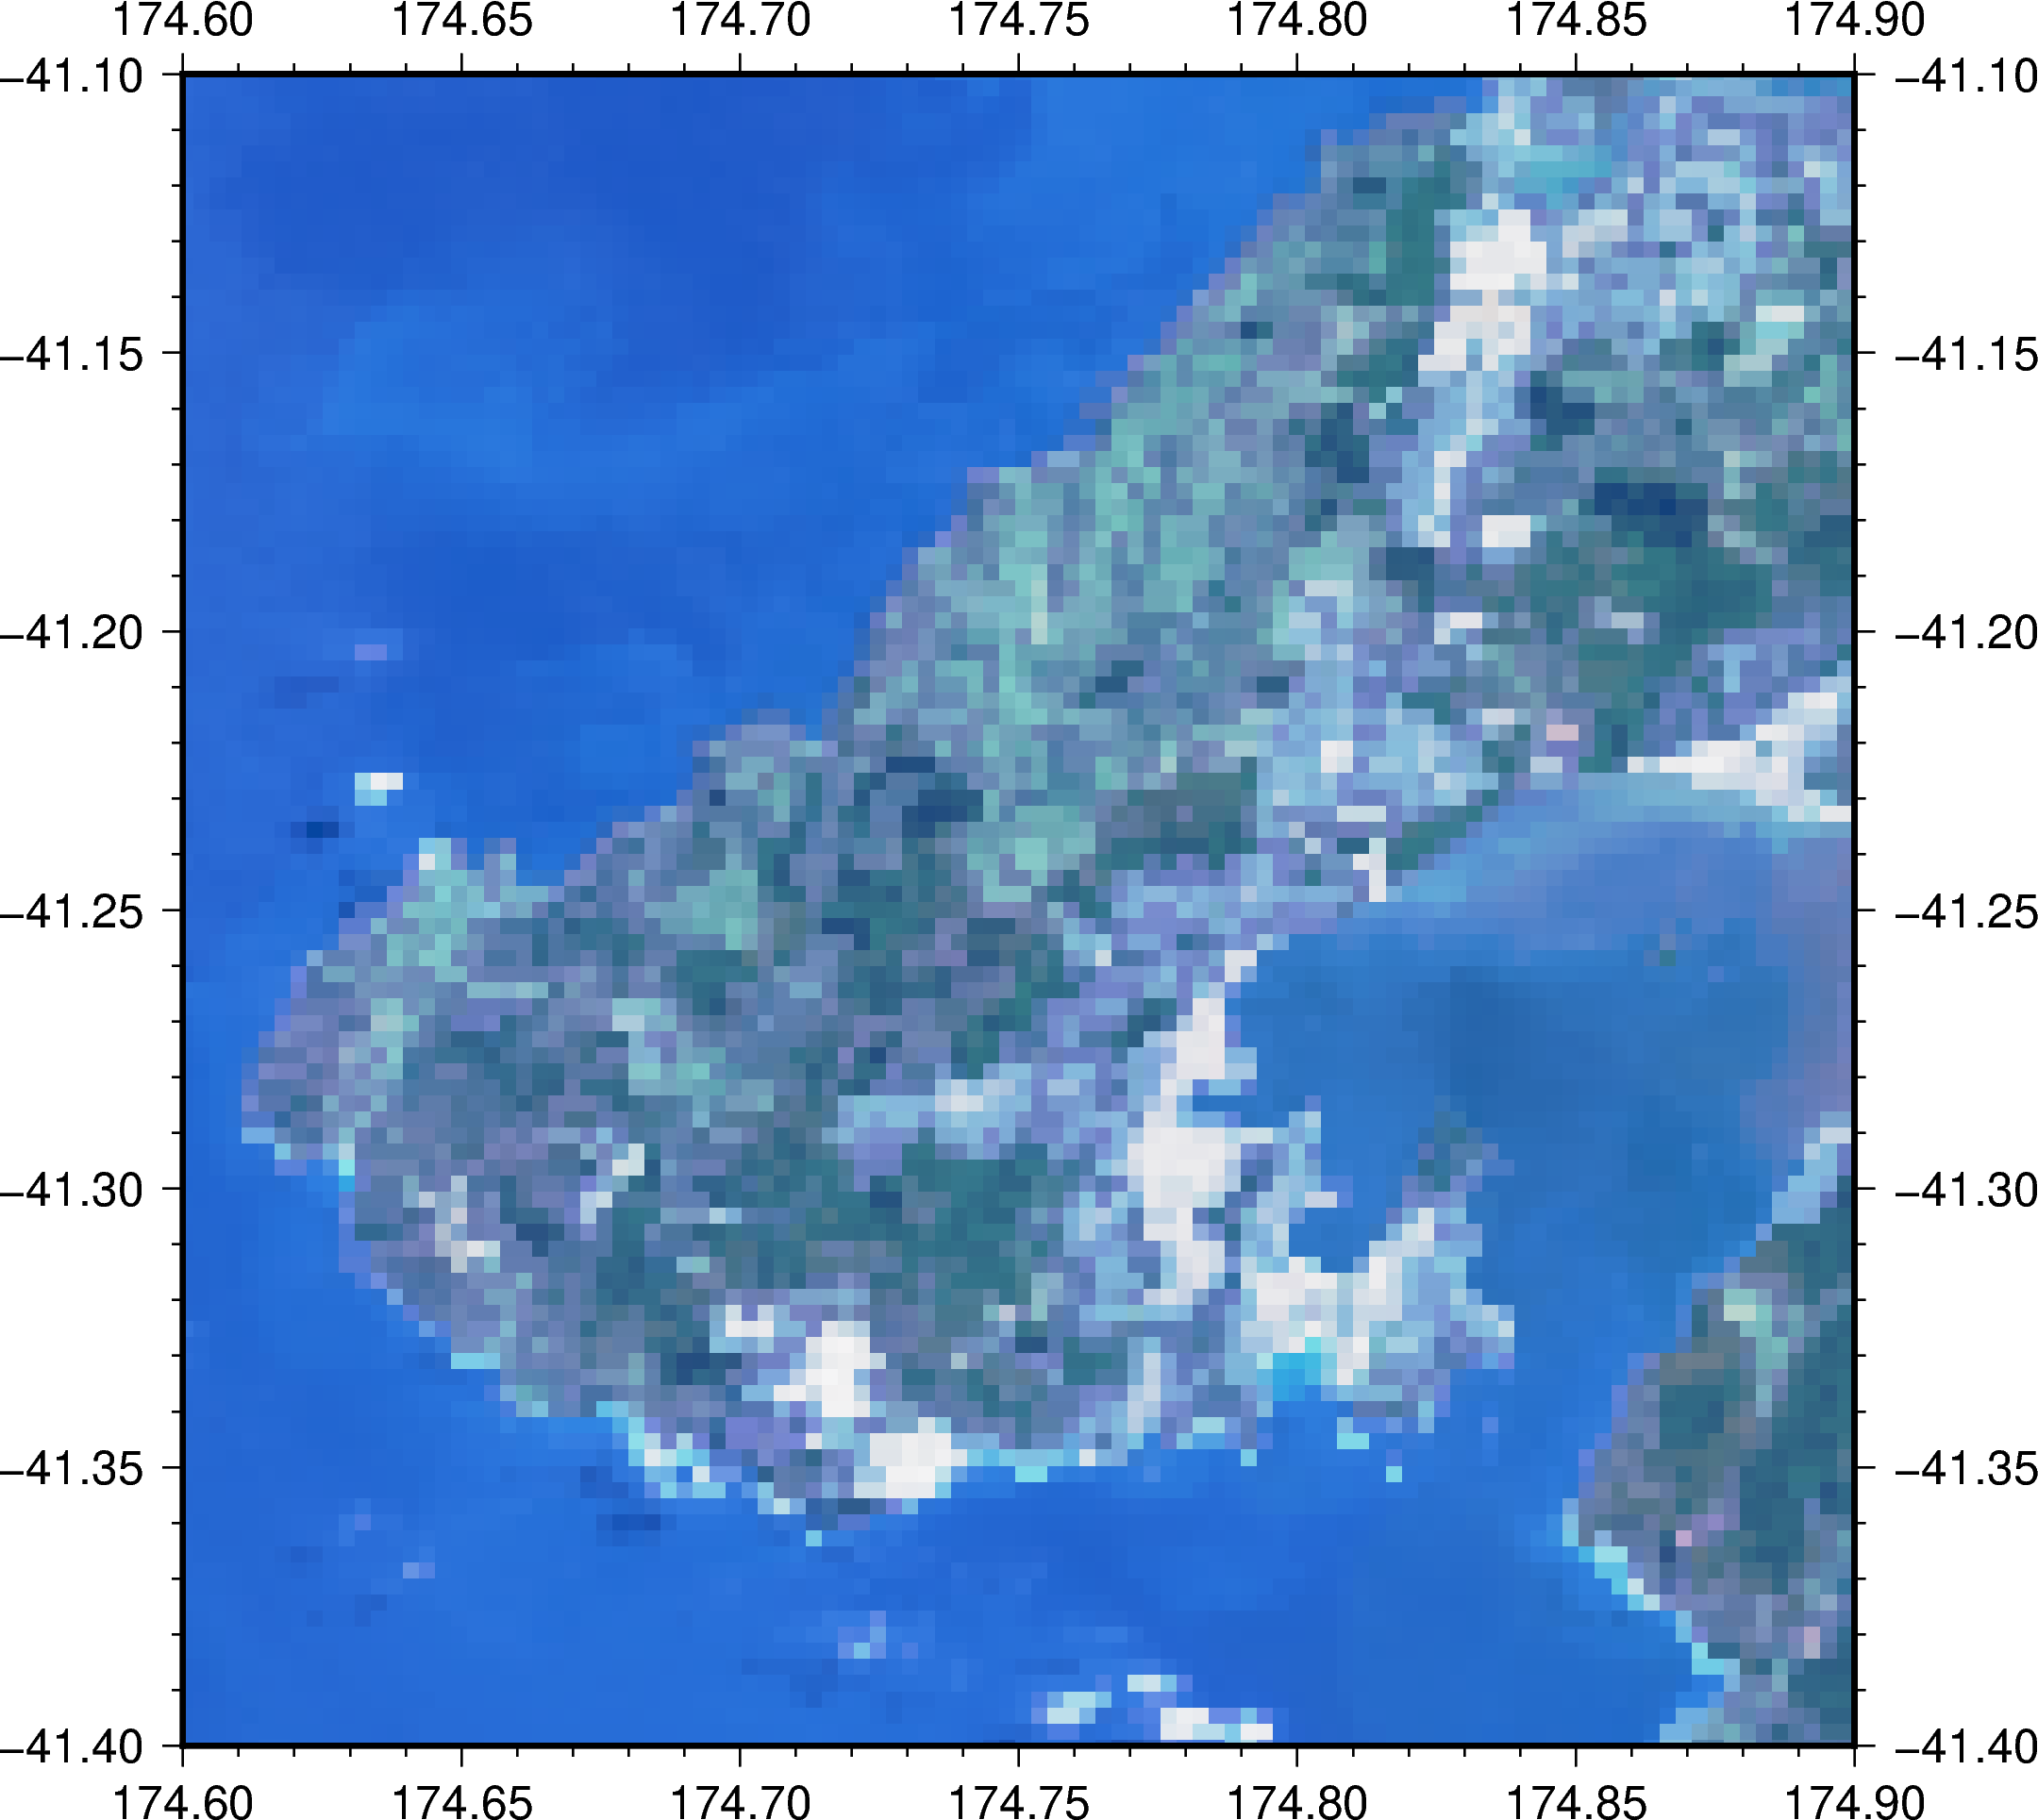

In [22]:
fig = pygmt.Figure()
fig.grdimage(
    grid=[grid.sel(band=4), grid.sel(band=3), grid.sel(band=2)],
    region=[174.6, 174.9, -41.4, -41.1],
    frame=True
)
fig.show()

## **2.4 Exploration time - Points or Grids, your pick**

It's time to make a map on your own again!
Depending on what you're interested in,
use one of the Search APIs linked above
(either the [GeoNet Quake Search](https://quakesearch.geonet.org.nz)
or [Remote Pixel's Satellite Search API](https://search.remotepixel.ca))
to pull in a good chunk of data for your city, town or region.

If you're plotting earthquake points,
try to play with different colormaps or change the size of the symbols.
If you're plotting Landsat 8 grids,
try to plot a false colour map instead or calculate
[NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) values
and plot it with a colorbar.

Go!

So far we've gone through a good chunk of PyGMT's plotting modules,
but there's a whole lot more to PyGMT than that!
Next on, we'll look at one example of PyGMT's data processing functionality.
Specifically, taking a point cloud and processing it into a Digital Elevation Model (DEM) grid!